Проект выполнили: Гламаздин Василий, Пиксаев Алексей, Андрианова Екатерина, Люков Дмитрий

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels as smt
from itertools import product

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

import warnings
warnings.filterwarnings('ignore')

import datetime
from dateutil.relativedelta import relativedelta

## Посмотрим на сырые данные

Выкачиваем данные. Временной промежуток ограничен с 15.03.2018 по 31.01.2019, причем отсутствуют выходные и праздничные дни.

In [ ]:
df_raw = pd.read_csv('project_2_data.csv', parse_dates=['date'])

df_raw = df_raw.set_index('date')
df_raw = df_raw.asfreq('B')

df_raw.head()

,target
date,
2018-03-15,1.0
2018-03-16,2.0
2018-03-19,17.0
2018-03-20,18.0
2018-03-21,19.0


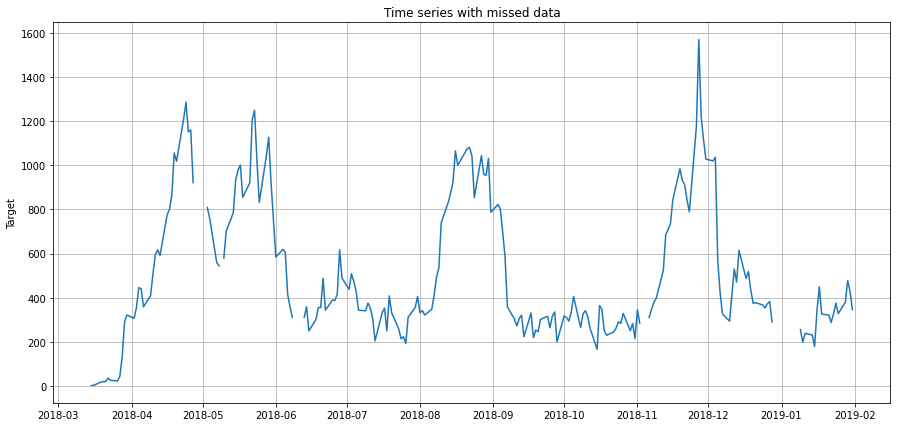

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(df_raw.target)
plt.ylabel('Target')
plt.grid()
plt.title('Time series with missed data')
plt.show()

Для анализа будем использовать данные без учета пропусков, а значения меньше 100 выбросим, так как они являются выбросами.

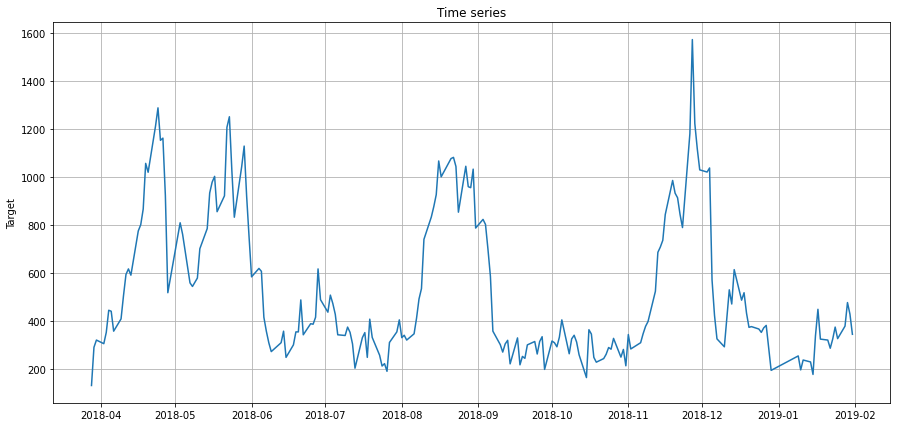

In [ ]:
df = pd.read_csv('project_2_data.csv', parse_dates=['date'], index_col=['date'])
df = df[df.target>100]

plt.figure(figsize=(15,7))
plt.plot(df.target)
plt.ylabel('Target')
plt.grid()
plt.title('Time series')
plt.show()

## Декомпозиция ряда

### Period = 60

На графике явно прослеживются три с половиной периода, в течение которых таргет претерпевал циклическое изменение, поэтому для исследования было выбрано значение периода, равное количеству дней в датасете, деленному на 3.5, т.е. примерно 60 дней. Посмотрим на графики аддитиввной и мультипликативной декомпозиций.

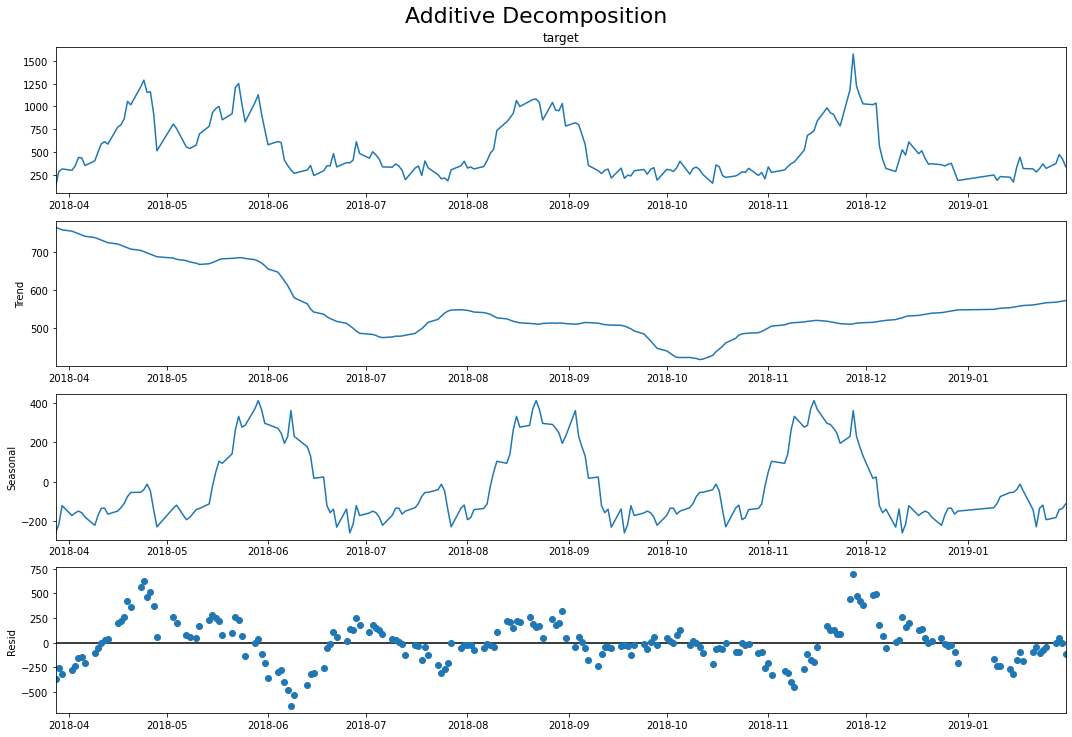

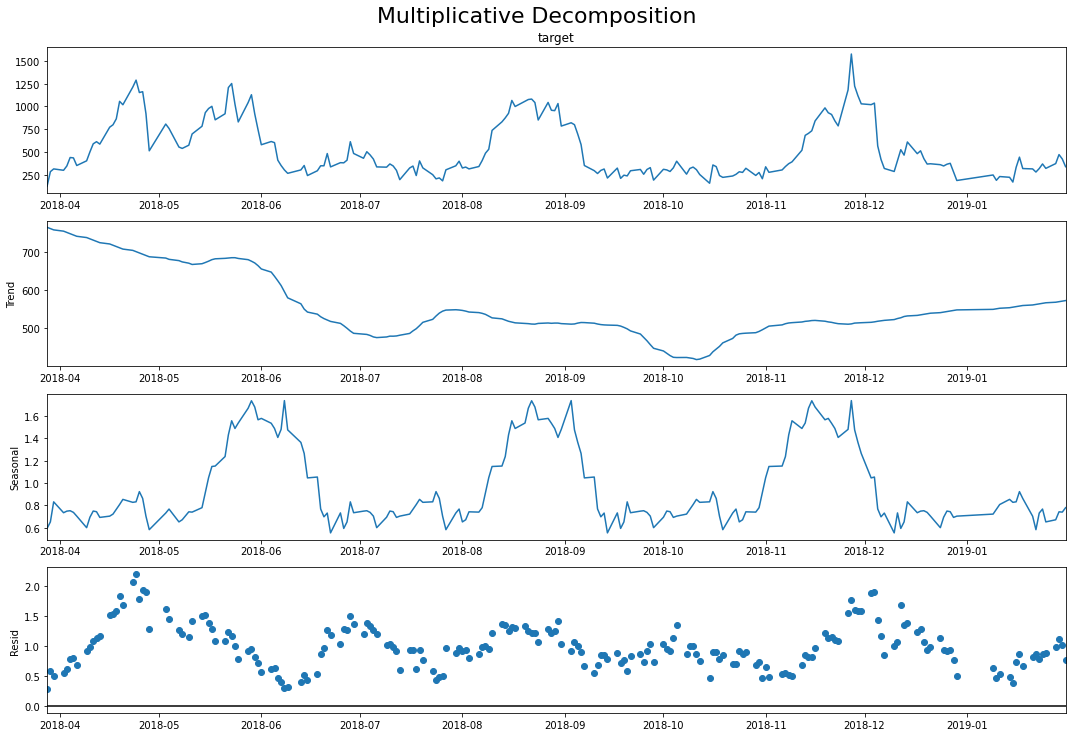

In [ ]:
period = 60

plt.rcParams["figure.figsize"] = (15,10)
stl_add = sm.tsa.seasonal_decompose(x = df['target'], model='additive', extrapolate_trend='freq', period=period)
stl_mult = sm.tsa.seasonal_decompose(x = df['target'], model='multiplicative', extrapolate_trend='freq', period=period)
stl_add.plot().suptitle('Additive Decomposition', fontsize=22, y=1.02)
stl_mult.plot().suptitle('Multiplicative Decomposition', fontsize=22, y=1.02)
plt.show()

Таким образом, для обеих моделей амплитуда сезонной составляющей постоянная, но остатки имеют повторяющуюся структуру. 

### Period = 5

Попробуем для интереса декомпозировать ряд с периодом, равным 5 дней, т.е. количеству рабочих дней в одной неделе.

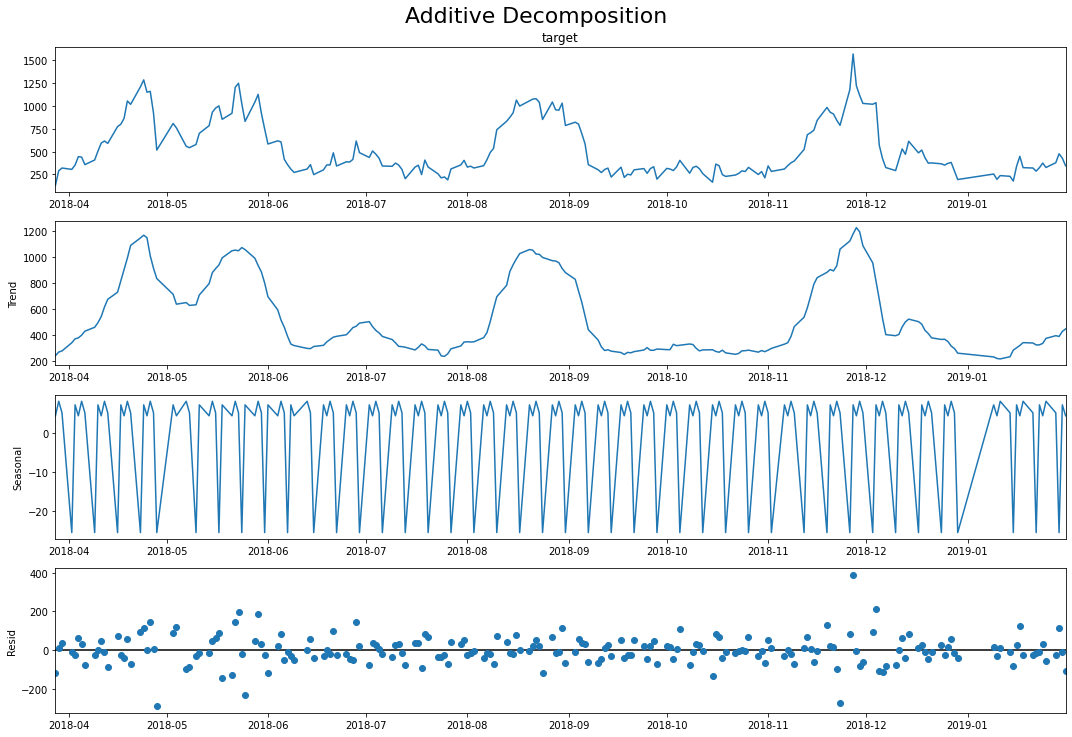

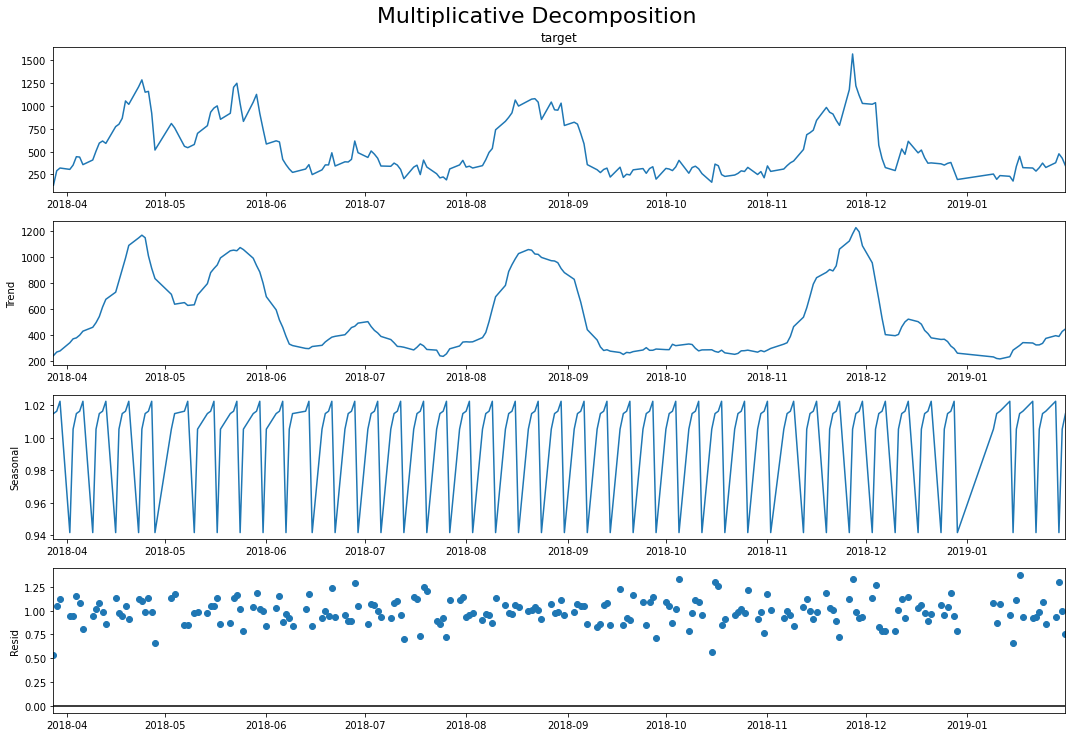

In [ ]:
period = 5

plt.rcParams["figure.figsize"] = (15,10)
stl_add = sm.tsa.seasonal_decompose(x = df['target'], model='additive', extrapolate_trend='freq', period=period)
stl_mult = sm.tsa.seasonal_decompose(x = df['target'], model='multiplicative', extrapolate_trend='freq', period=period)
stl_add.plot().suptitle('Additive Decomposition', fontsize=22, y=1.02)
stl_mult.plot().suptitle('Multiplicative Decomposition', fontsize=22, y=1.02)
plt.show()

Для данного периода остатки имеют более случайную структуру. 

## Проверка на стационарность

Тест Дики-Фуллера (DF):


*   $H_0$: ряд нестационарный
*   $H_1$: ряд стационарный


In [ ]:
print("Критерий DF: p=%f" % sm.tsa.stattools.adfuller(df.target)[1])

Критерий DF: p=0.003570


Отвергаем $H_0$ о нестационарности ряда на 5% уровне значимости в соответствии с критерием DF.

Тест Квятковского-Филлипса-Шмидта-Шина (KPSS):
*   $H_0$: ряд стационарный
*   $H_1$: ряд нестационарный

In [ ]:
print("Критерий KPSS: p=%f" % sm.tsa.stattools.kpss(df.target)[1])

Критерий KPSS: p=0.100000


Не отвергаем гипотезу $H_0$ о стационарности ряда на 5% уровне значимости в соответствии с критерием KPSS.

Тест филлипса-Перрона (FP):


*   $H_0$: ряд нестационарный
*   $H_1$: ряд стационарный


In [ ]:
print("Критерий FP: p=%f" % PhillipsPerron(df.target).pvalue)

Критерий FP: p=0.015811


Отвергаем $H_0$ о нестационарности ряда на 5% уровне значимости в соответствии с критерием FP.

## Дифференцирование

Статистические тесты Дики-Фуллера и Филлипса-Перрона отвергают гипотезу о нестационарности ряда. Статистический тест КПСС не отвергает гипотезу о стационарности. Однако график выглядит не очень стационарно, попробуем продифференцировать ряды для обоих периодов.

### Period = 60

Тест Dickey Fuller:
ADF Statistic: -3.146099120998182
p-value: 0.023324465468927313
Critial Values:
   1%, -3.474714913481481
Critial Values:
   5%, -2.881008708148148
Critial Values:
   10%, -2.5771508444444446
Тест DF: p-value=0.0233
Тест PP: p-value=0.0117
Тест KPSS: p-value=0.1000


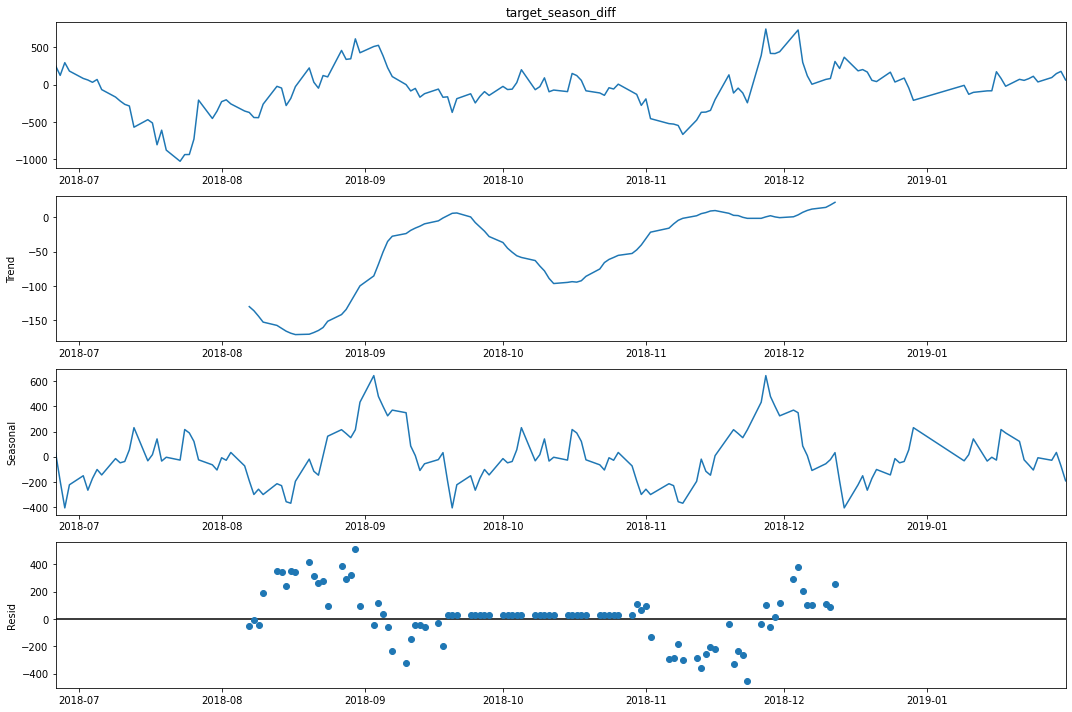

In [ ]:
period = 60

df['target_season_diff'] = df.target - df.target.shift(period)

print('Тест Dickey Fuller:')
result = adfuller(df.target_season_diff.dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

print('Тест DF: p-value=%.4f' % adfuller(df.target_season_diff.dropna())[1])
print('Тест PP: p-value=%.4f' % PhillipsPerron(df.target_season_diff.dropna()).pvalue)
print('Тест KPSS: p-value=%.4f' % kpss(df.target_season_diff.dropna())[1])

seasonal_decompose(df['target_season_diff'][period:], period=period).plot() 
plt.show()

Тест Dickey Fuller:
ADF Statistic: -5.215528644864264
p-value: 8.172457834741638e-06
Critial Values:
   1%, -3.462980134086401
Critial Values:
   5%, -2.875885461947131
Critial Values:
   10%, -2.5744164898444515
Тест DF: p-value=0.0000
Тест PP: p-value=0.0000
Тест KPSS: p-value=0.1000


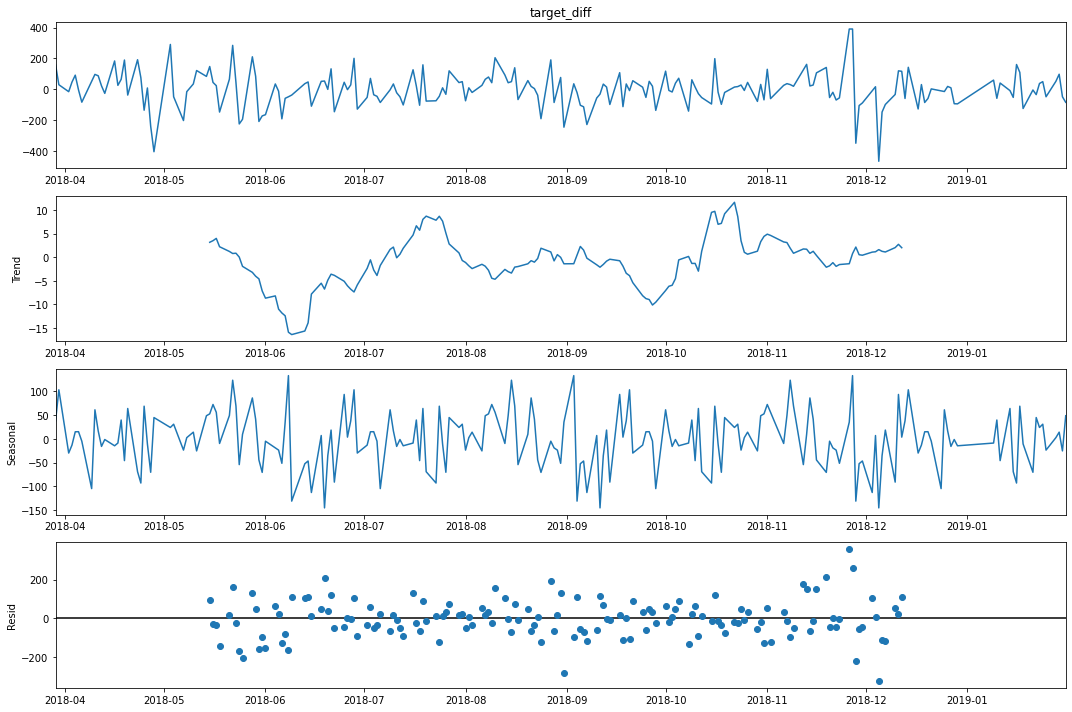

In [ ]:
df['target_diff'] = df.target - df.target.shift(1)

print('Тест Dickey Fuller:')
result = adfuller(df.target_diff.dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

print('Тест DF: p-value=%.4f' % adfuller(df.target_diff.dropna())[1])
print('Тест PP: p-value=%.4f' % PhillipsPerron(df.target_diff.dropna()).pvalue)
print('Тест KPSS: p-value=%.4f' % kpss(df.target_diff.dropna())[1])

seasonal_decompose(df['target_diff'][1:], period=period).plot() 
plt.show()

Тест Dickey Fuller:
ADF Statistic: -10.311546656586085
p-value: 3.1757788962018846e-18
Critial Values:
   1%, -3.4753253063120644
Critial Values:
   5%, -2.881274703275226
Critial Values:
   10%, -2.5772928360116873
Тест DF: p-value=0.0000
Тест PP: p-value=0.0000
Тест KPSS: p-value=0.1000


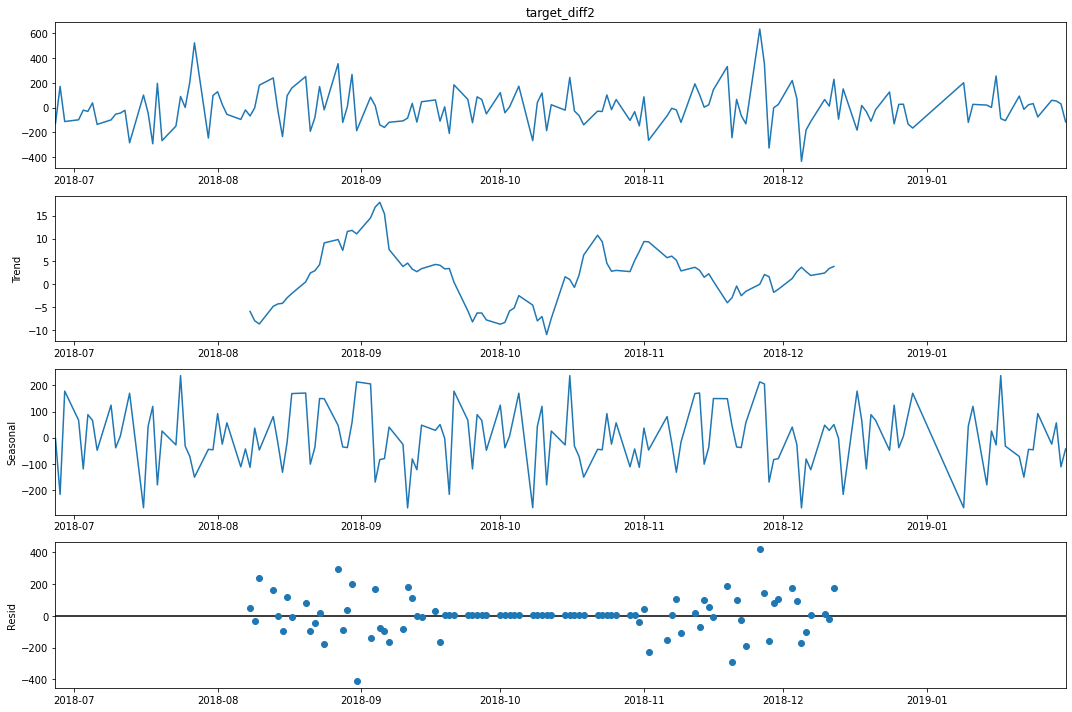

In [ ]:
df['target_diff2'] = df.target_season_diff - df.target_season_diff.shift(1)

print('Тест Dickey Fuller:')
result = adfuller(df.target_diff2.dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

print('Тест DF: p-value=%.4f' % adfuller(df.target_diff2.dropna())[1])
print('Тест PP: p-value=%.4f' % PhillipsPerron(df.target_diff2.dropna()).pvalue)
print('Тест KPSS: p-value=%.4f' % kpss(df.target_diff2.dropna())[1])

seasonal_decompose(df['target_diff2'][period+1:], period=period).plot() 
plt.show()

### Period = 5

Тест Dickey Fuller:
ADF Statistic: -5.096876750983151
p-value: 1.4223142346708428e-05
Critial Values:
   1%, -3.4648754262570978
Critial Values:
   5%, -2.876714157488788
Critial Values:
   10%, -2.574858699001736
Тест DF: p-value=0.0000
Тест PP: p-value=0.0020
Тест KPSS: p-value=0.1000


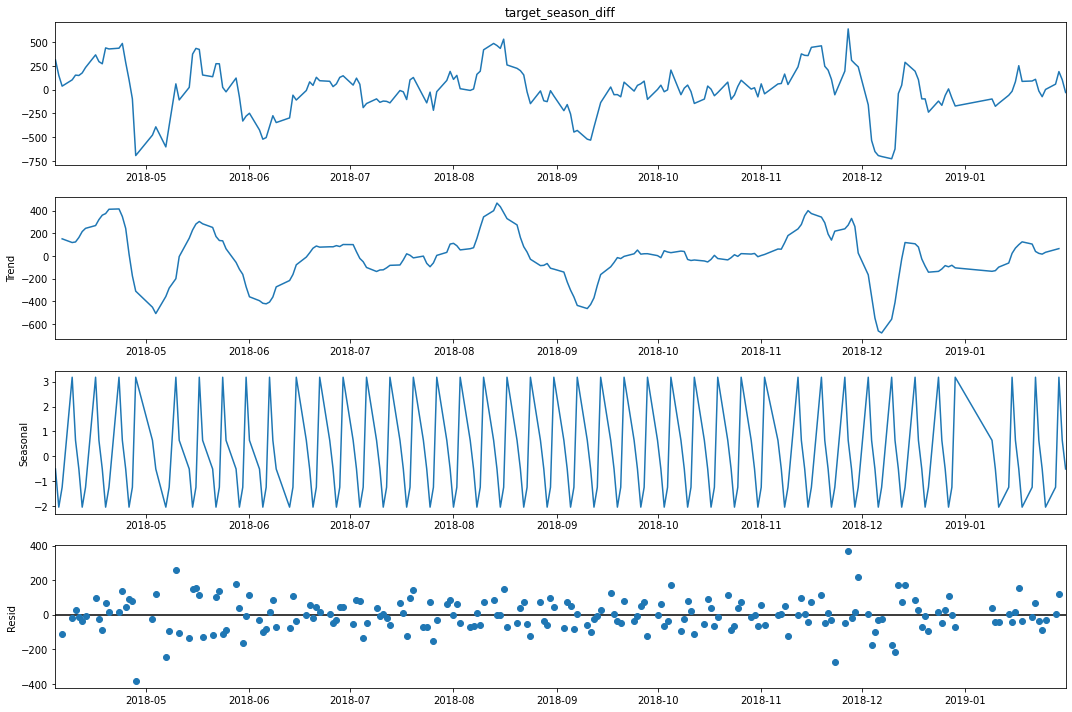

In [ ]:
period = 5

df['target_season_diff'] = df.target - df.target.shift(period)

print('Тест Dickey Fuller:')
result = adfuller(df.target_season_diff.dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

print('Тест DF: p-value=%.4f' % adfuller(df.target_season_diff.dropna())[1])
print('Тест PP: p-value=%.4f' % PhillipsPerron(df.target_season_diff.dropna()).pvalue)
print('Тест KPSS: p-value=%.4f' % kpss(df.target_season_diff.dropna())[1])

seasonal_decompose(df['target_season_diff'][period:], period=period).plot() 
plt.show()

Тест Dickey Fuller:
ADF Statistic: -5.215528644864264
p-value: 8.172457834741638e-06
Critial Values:
   1%, -3.462980134086401
Critial Values:
   5%, -2.875885461947131
Critial Values:
   10%, -2.5744164898444515
Тест DF: p-value=0.0000
Тест PP: p-value=0.0000
Тест KPSS: p-value=0.1000


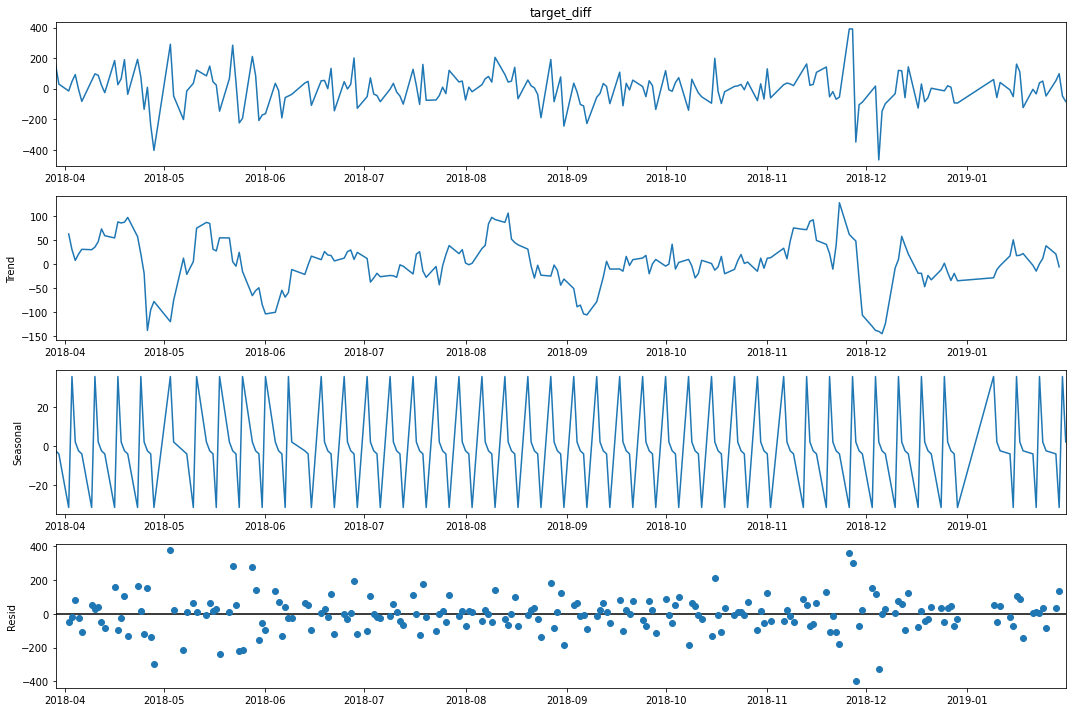

In [ ]:
df['target_diff'] = df.target - df.target.shift(1)

print('Тест Dickey Fuller:')
result = adfuller(df.target_diff.dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

print('Тест DF: p-value=%.4f' % adfuller(df.target_diff.dropna())[1])
print('Тест PP: p-value=%.4f' % PhillipsPerron(df.target_diff.dropna()).pvalue)
print('Тест KPSS: p-value=%.4f' % kpss(df.target_diff.dropna())[1])

seasonal_decompose(df['target_diff'][1:], period=period).plot() 
plt.show()

Тест Dickey Fuller:
ADF Statistic: -5.939424567229922
p-value: 2.2795894920985123e-07
Critial Values:
   1%, -3.4652439354133255
Critial Values:
   5%, -2.8768752281673717
Critial Values:
   10%, -2.574944653739612
Тест DF: p-value=0.0000
Тест PP: p-value=0.0000
Тест KPSS: p-value=0.1000


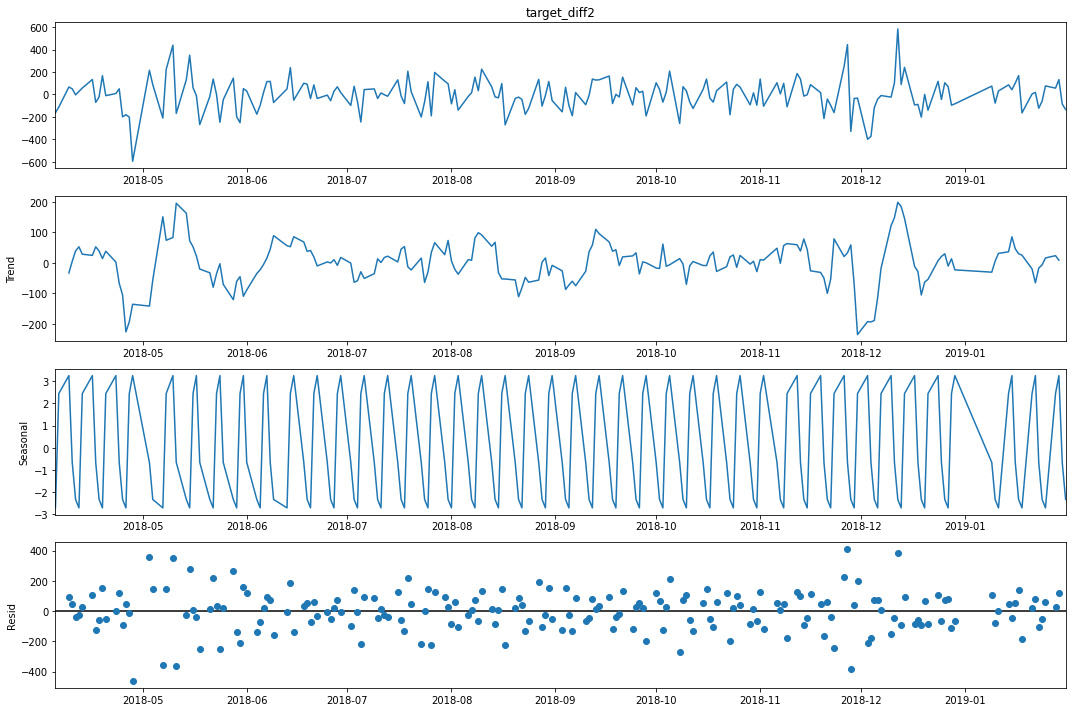

In [ ]:
df['target_diff2'] = df.target_season_diff - df.target_season_diff.shift(1)

print('Тест Dickey Fuller:')
result = adfuller(df.target_diff2.dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

print('Тест DF: p-value=%.4f' % adfuller(df.target_diff2.dropna())[1])
print('Тест PP: p-value=%.4f' % PhillipsPerron(df.target_diff2.dropna()).pvalue)
print('Тест KPSS: p-value=%.4f' % kpss(df.target_diff2.dropna())[1])

seasonal_decompose(df['target_diff2'][period+1:], period=period).plot() 
plt.show()

Для всех сделанных выше дифференцирований статистические тесты Дики-Фуллера и Филлипса-Перрона отвергают гипотезу о нестационарности ряда. Статистический тест КПСС не отвергает гипотезу о стационарности. Построим модели для каждого из дифференцированных рядов. Но распределение остатков ближе к нормальному у второго ряда модели с периодом, равным 60, следовательно, приоритетом будет считать его.

## Моделирование

Будем использовать SARIMAX для обоих периодов.

In [ ]:
def fit_model(ts, params, d, D, period):
    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')

    for param in params:
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(ts, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], period)).fit(disp=-1)
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    warnings.filterwarnings('default')
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by = 'aic', ascending=True)

    return best_model, result_table

### Period = 5

In [ ]:
period = 5
df['target_season_diff_5'] = df.target - df.target.shift(period)
df['target_diff2_5'] = df.target_season_diff_5 - df.target_season_diff_5.shift(1)

#### 1. Ряд с сезонной и обычной разностью (d=D=1):

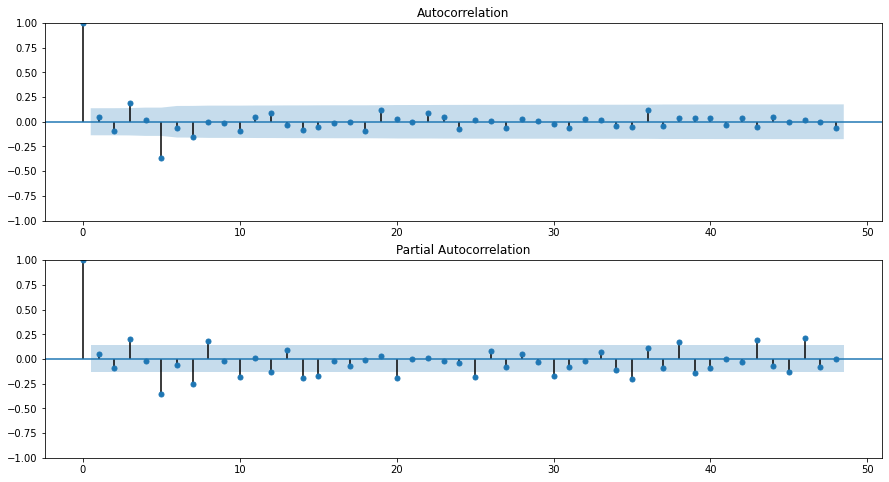

In [ ]:
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot(211)
plot_acf(df.target_diff2_5[period+1:].values.squeeze(), lags=48, ax=ax1)
ax2 = plt.subplot(212)
plot_pacf(df.target_diff2_5[period+1:].values.squeeze(), lags=48, ax=ax2)
fig.show()

In [ ]:
%%time

ps = range(0, 11)
d = 1
qs = range(0, 11)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)

parameters_list = list(product(ps, qs, Ps, Qs))

model_diff2_5, result = fit_model(df.target, parameters_list, d, D, period)

result.head()

wrong parameters: (0, 5, 0, 1)
wrong parameters: (0, 5, 1, 1)
wrong parameters: (0, 6, 0, 1)
wrong parameters: (0, 6, 1, 1)
wrong parameters: (0, 7, 0, 1)
wrong parameters: (0, 7, 1, 1)
wrong parameters: (0, 8, 0, 1)
wrong parameters: (0, 8, 1, 1)
wrong parameters: (0, 9, 0, 1)
wrong parameters: (0, 9, 1, 1)
wrong parameters: (0, 10, 0, 1)
wrong parameters: (0, 10, 1, 1)
wrong parameters: (1, 5, 0, 1)
wrong parameters: (1, 5, 1, 1)
wrong parameters: (1, 6, 0, 1)
wrong parameters: (1, 6, 1, 1)
wrong parameters: (1, 7, 0, 1)
wrong parameters: (1, 7, 1, 1)
wrong parameters: (1, 8, 0, 1)
wrong parameters: (1, 8, 1, 1)
wrong parameters: (1, 9, 0, 1)
wrong parameters: (1, 9, 1, 1)
wrong parameters: (1, 10, 0, 1)
wrong parameters: (1, 10, 1, 1)
wrong parameters: (2, 5, 0, 1)
wrong parameters: (2, 5, 1, 1)
wrong parameters: (2, 6, 0, 1)
wrong parameters: (2, 6, 1, 1)
wrong parameters: (2, 7, 0, 1)
wrong parameters: (2, 7, 1, 1)
wrong parameters: (2, 8, 0, 1)
wrong parameters: (2, 8, 1, 1)
wron

In [ ]:
print(model_diff2_5.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              target   No. Observations:                  211
Model:             SARIMAX(7, 1, 0)x(0, 1, [1], 5)   Log Likelihood               -1259.042
Date:                             Sun, 13 Mar 2022   AIC                           2536.085
Time:                                     18:41:40   BIC                           2565.992
Sample:                                          0   HQIC                          2548.182
                                             - 211                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0786      0.053      1.489      0.137      -0.025       0.182
ar.L2         -0.1314      

Критерий Стьюдента: p=0.225031
Критерий Дики-Фуллера: p=0.000000


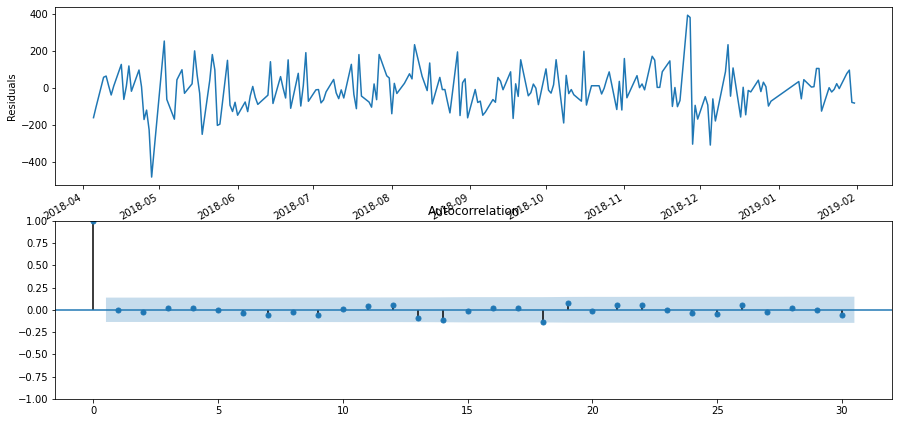

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(211)
model_diff2_5.resid[period+1:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
plot_acf(model_diff2_5.resid[period+1:].values.squeeze(), lags=30, ax=ax)

print("Критерий Стьюдента: p=%f" % scs.ttest_1samp(model_diff2_5.resid[period+1:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % adfuller(model_diff2_5.resid[period+1:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). 

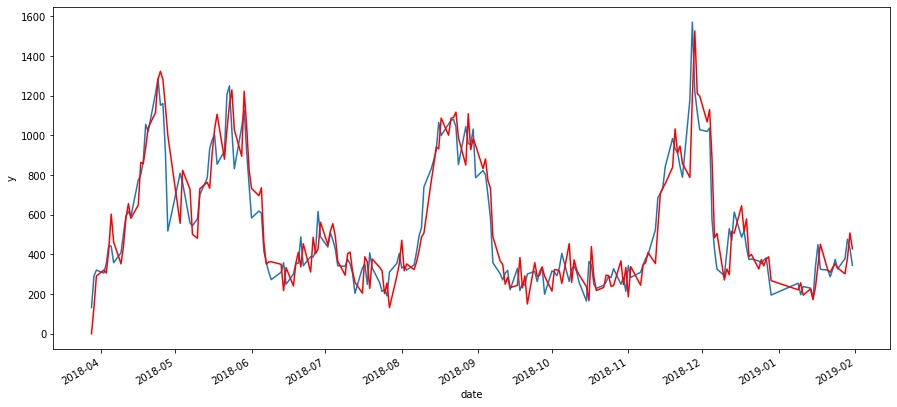

In [ ]:
y_true = df.target
y_pred = model_diff2_5.fittedvalues

plt.figure(figsize=(15,7))
y_true.plot()
y_pred.plot(color='r')
plt.ylabel('y')
plt.show()

Прогнозируем:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


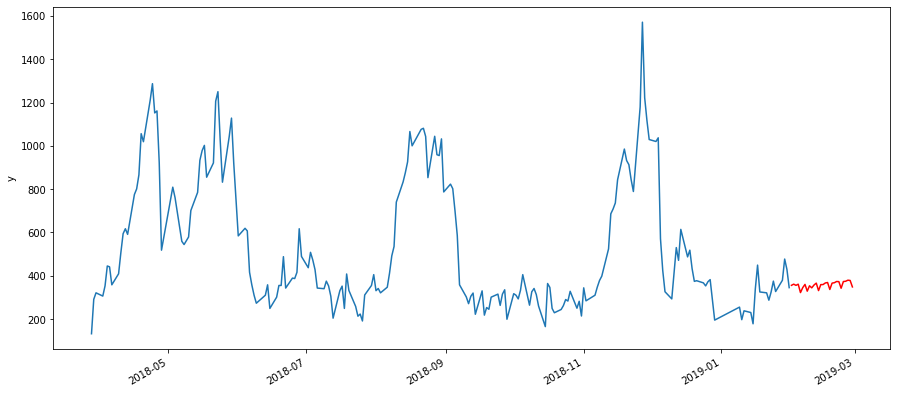

In [ ]:
diff2_5_forecast = df[['target']]
date_list = [datetime.datetime.strptime("2019-02-01", "%Y-%m-%d") + relativedelta(days=x) for x in range(0,28)]
future = pd.DataFrame(index=date_list, columns=diff2_5_forecast.columns)
diff2_5_forecast = pd.concat([diff2_5_forecast, future])
diff2_5_forecast['forecast'] = np.nan
diff2_5_forecast['forecast'][-28:] = model_diff2_5.forecast(28)

plt.figure(figsize=(15,7))
diff2_5_forecast.target.plot()
diff2_5_forecast.forecast.plot(color='r')
plt.ylabel('y')
plt.show()

In [ ]:
diff2_5_forecast

,target,forecast
2018-03-28,132,NaN
2018-03-29,291,NaN
2018-03-30,321,NaN
2018-04-02,306,NaN
2018-04-03,353,NaN
...,...,...
2019-02-24,NaN,373.069710
2019-02-25,NaN,374.407801
2019-02-26,NaN,379.350533
2019-02-27,NaN,378.112471


#### 2. Ряд с сезонной разностью (d=0, D=1):

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


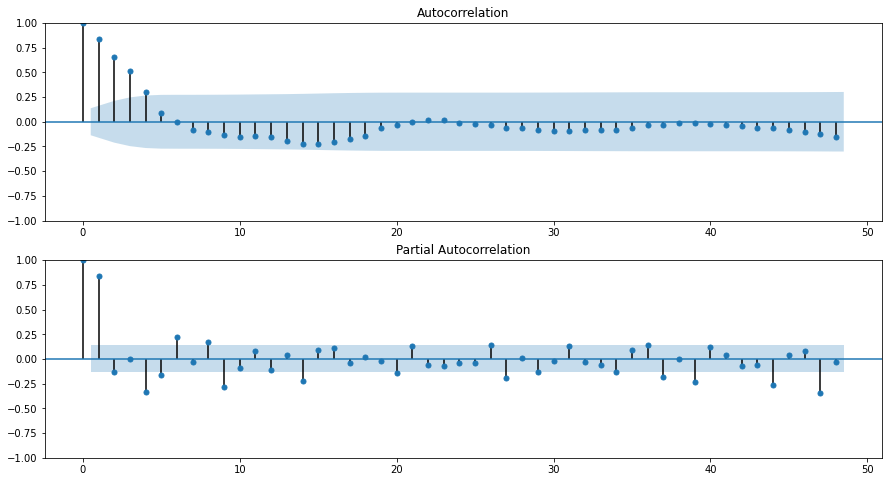

In [ ]:
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot(211)
plot_acf(df.target_season_diff_5[period:].values.squeeze(), lags=48, ax=ax1)
ax2 = plt.subplot(212)
plot_pacf(df.target_season_diff_5[period:].values.squeeze(), lags=48, ax=ax2)
fig.show()

In [ ]:
%%time

ps = range(0, 10)
d = 0
qs = range(0, 7)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)

parameters_list = list(product(ps, qs, Ps, Qs))

model_seas_diff_5, result = fit_model(df.target, parameters_list, d, D, period)

result.head()

wrong parameters: (0, 5, 0, 1)
wrong parameters: (0, 5, 1, 1)
wrong parameters: (0, 6, 0, 1)
wrong parameters: (0, 6, 1, 1)
wrong parameters: (1, 5, 0, 1)
wrong parameters: (1, 5, 1, 1)
wrong parameters: (1, 6, 0, 1)
wrong parameters: (1, 6, 1, 1)
wrong parameters: (2, 5, 0, 1)
wrong parameters: (2, 5, 1, 1)
wrong parameters: (2, 6, 0, 1)
wrong parameters: (2, 6, 1, 1)
wrong parameters: (3, 5, 0, 1)
wrong parameters: (3, 5, 1, 1)
wrong parameters: (3, 6, 0, 1)
wrong parameters: (3, 6, 1, 1)
wrong parameters: (4, 5, 0, 1)
wrong parameters: (4, 5, 1, 1)
wrong parameters: (4, 6, 0, 1)
wrong parameters: (4, 6, 1, 1)
wrong parameters: (5, 0, 1, 0)
wrong parameters: (5, 0, 1, 1)
wrong parameters: (5, 1, 1, 0)
wrong parameters: (5, 1, 1, 1)
wrong parameters: (5, 2, 1, 0)
wrong parameters: (5, 2, 1, 1)
wrong parameters: (5, 3, 1, 0)
wrong parameters: (5, 3, 1, 1)
wrong parameters: (5, 4, 1, 0)
wrong parameters: (5, 4, 1, 1)
wrong parameters: (5, 5, 0, 1)
wrong parameters: (5, 5, 1, 0)
wrong pa

In [ ]:
print(model_seas_diff_5.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              target   No. Observations:                  211
Model:             SARIMAX(6, 0, 0)x(0, 1, [1], 5)   Log Likelihood               -1260.701
Date:                             Sun, 13 Mar 2022   AIC                           2537.403
Time:                                     18:51:10   BIC                           2564.026
Sample:                                          0   HQIC                          2548.170
                                             - 211                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0187      0.050     20.273      0.000       0.920       1.117
ar.L2         -0.2336      

Критерий Стьюдента: p=0.957801
Критерий Дики-Фуллера: p=0.000000


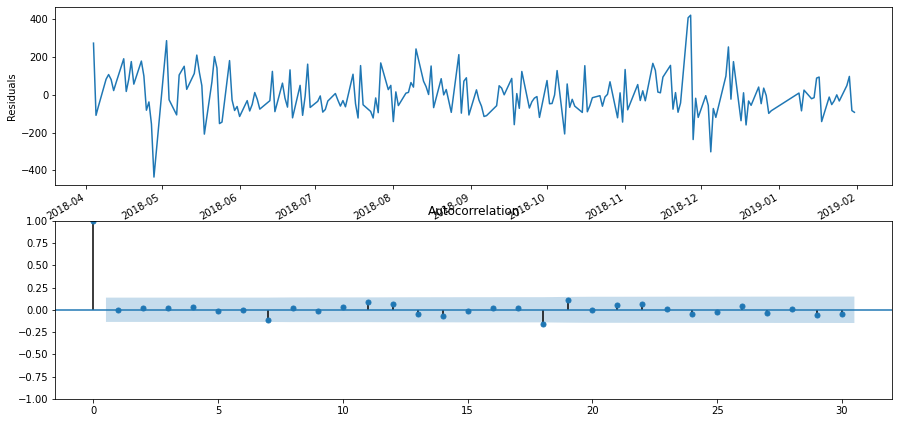

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(211)
model_seas_diff_5.resid[5:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
plot_acf(model_seas_diff_5.resid[5:].values.squeeze(), lags=30, ax=ax)

print("Критерий Стьюдента: p=%f" % scs.ttest_1samp(model_seas_diff_5.resid[5:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % adfuller(model_seas_diff_5.resid[5:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). 

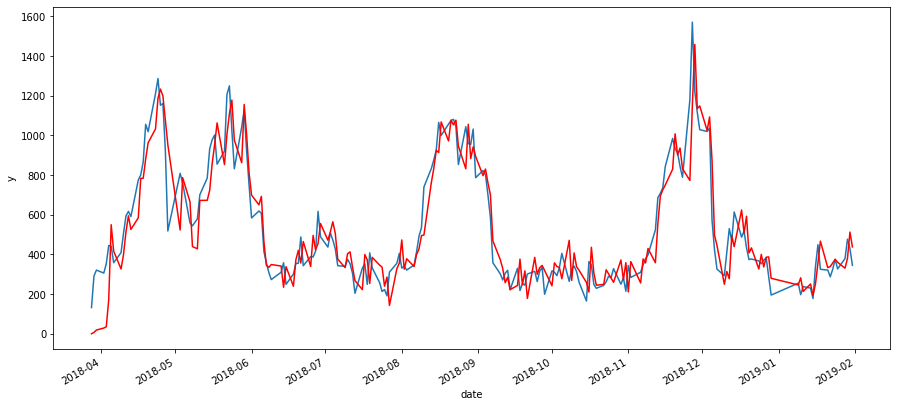

In [ ]:
y_true = df.target
y_pred = model_seas_diff_5.fittedvalues

plt.figure(figsize=(15,7))
y_true.plot()
y_pred.plot(color='r')
plt.ylabel('y')
plt.show()

Прогнозируем:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


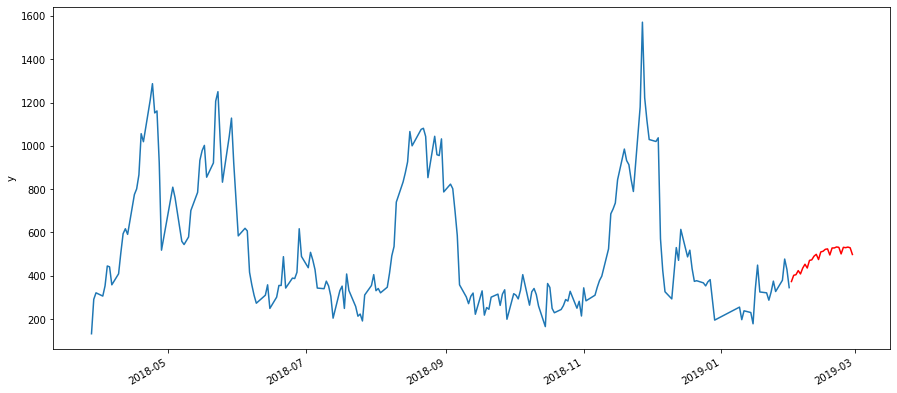

In [ ]:
seas_diff_5_forecast = df[['target']]
date_list = [datetime.datetime.strptime("2019-02-01", "%Y-%m-%d") + relativedelta(days=x) for x in range(0,28)]
future = pd.DataFrame(index=date_list, columns=seas_diff_5_forecast.columns)
seas_diff_5_forecast = pd.concat([seas_diff_5_forecast, future])
seas_diff_5_forecast['forecast'] = np.nan
seas_diff_5_forecast['forecast'][-28:] = model_seas_diff_5.forecast(28)

plt.figure(figsize=(15,7))
seas_diff_5_forecast.target.plot()
seas_diff_5_forecast.forecast.plot(color='r')
plt.ylabel('y')
plt.show()

In [ ]:
seas_diff_5_forecast

,target,forecast
2018-03-28,132,NaN
2018-03-29,291,NaN
2018-03-30,321,NaN
2018-04-02,306,NaN
2018-04-03,353,NaN
...,...,...
2019-02-24,NaN,531.083341
2019-02-25,NaN,529.639610
2019-02-26,NaN,532.276011
2019-02-27,NaN,529.123543


#### 3. Ряд с обычной разностью (d=1, D=0):

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


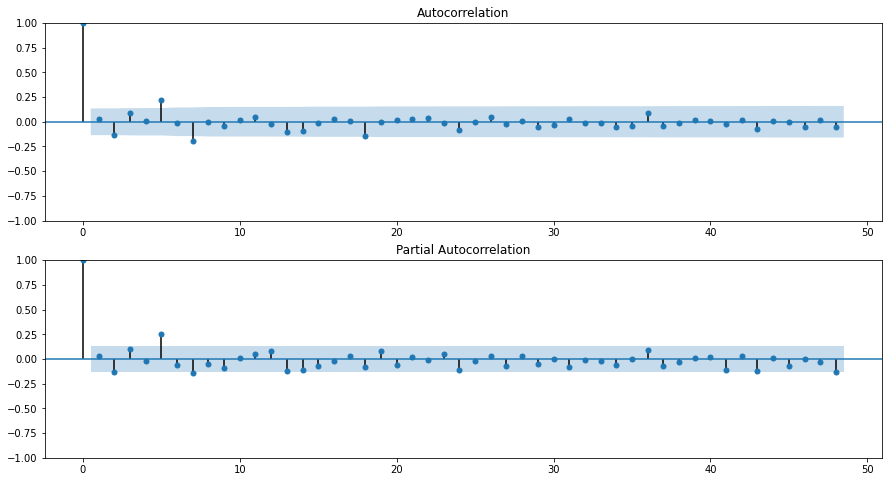

In [ ]:
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot(211)
plot_acf(df.target_diff[1:].values.squeeze(), lags=48, ax=ax1)
ax2 = plt.subplot(212)
plot_pacf(df.target_diff[1:].values.squeeze(), lags=48, ax=ax2)
plt.show()

In [ ]:
%%time

ps = range(0, 6)
d = 1
qs = range(0, 9)
Ps = range(0, 2)
D = 0
Qs = range(0, 2)

parameters_list = list(product(ps, qs, Ps, Qs))

model_diff, result = fit_model(df.target, parameters_list, d, D, period)

result.head()

wrong parameters: (0, 5, 0, 1)
wrong parameters: (0, 5, 1, 1)
wrong parameters: (0, 6, 0, 1)
wrong parameters: (0, 6, 1, 1)
wrong parameters: (0, 7, 0, 1)
wrong parameters: (0, 7, 1, 1)
wrong parameters: (0, 8, 0, 1)
wrong parameters: (0, 8, 1, 1)
wrong parameters: (1, 5, 0, 1)
wrong parameters: (1, 5, 1, 1)
wrong parameters: (1, 6, 0, 1)
wrong parameters: (1, 6, 1, 1)
wrong parameters: (1, 7, 0, 1)
wrong parameters: (1, 7, 1, 1)
wrong parameters: (1, 8, 0, 1)
wrong parameters: (1, 8, 1, 1)
wrong parameters: (2, 5, 0, 1)
wrong parameters: (2, 5, 1, 1)
wrong parameters: (2, 6, 0, 1)
wrong parameters: (2, 6, 1, 1)
wrong parameters: (2, 7, 0, 1)
wrong parameters: (2, 7, 1, 1)
wrong parameters: (2, 8, 0, 1)
wrong parameters: (2, 8, 1, 1)
wrong parameters: (3, 5, 0, 1)
wrong parameters: (3, 5, 1, 1)
wrong parameters: (3, 6, 0, 1)
wrong parameters: (3, 6, 1, 1)
wrong parameters: (3, 7, 0, 1)
wrong parameters: (3, 7, 1, 1)
wrong parameters: (3, 8, 0, 1)
wrong parameters: (3, 8, 1, 1)
wrong pa

In [ ]:
print(model_diff.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             target   No. Observations:                  211
Model:             SARIMAX(1, 1, 5)x(1, 0, [], 5)   Log Likelihood               -1277.961
Date:                            Sun, 13 Mar 2022   AIC                           2571.922
Time:                                    18:53:36   BIC                           2598.699
Sample:                                         0   HQIC                          2582.747
                                            - 211                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7853      0.118      6.656      0.000       0.554       1.017
ma.L1         -0.7860      2.765   

Критерий Стьюдента: p=0.904050
Критерий Дики-Фуллера: p=0.000000


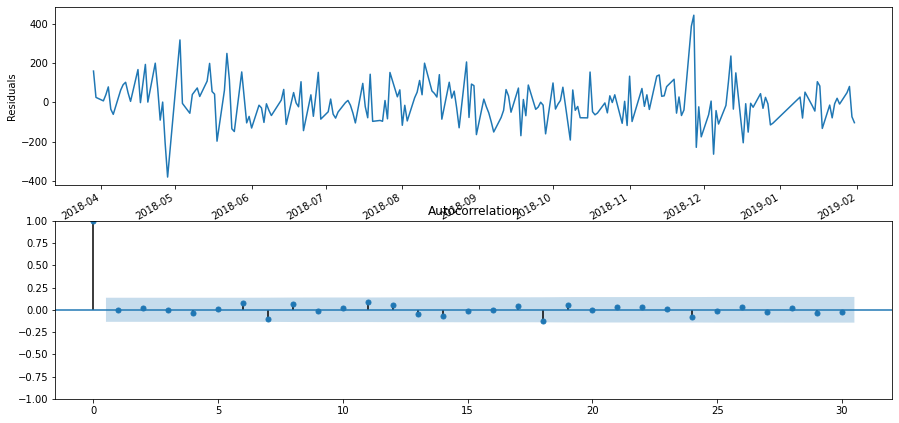

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(211)
model_diff.resid[1:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
plot_acf(model_diff.resid[1:].values.squeeze(), lags=30, ax=ax)

print("Критерий Стьюдента: p=%f" % scs.ttest_1samp(model_diff.resid[1:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % adfuller(model_diff.resid[1:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). 

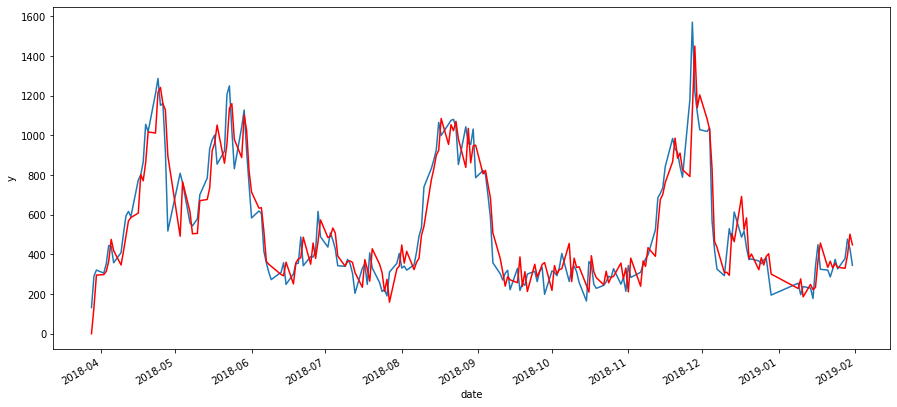

In [ ]:
y_true = df.target
y_pred = model_diff.fittedvalues

plt.figure(figsize=(15,7))
y_true.plot()
y_pred.plot(color='r')
plt.ylabel('y')
plt.show()

Прогнозируем:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


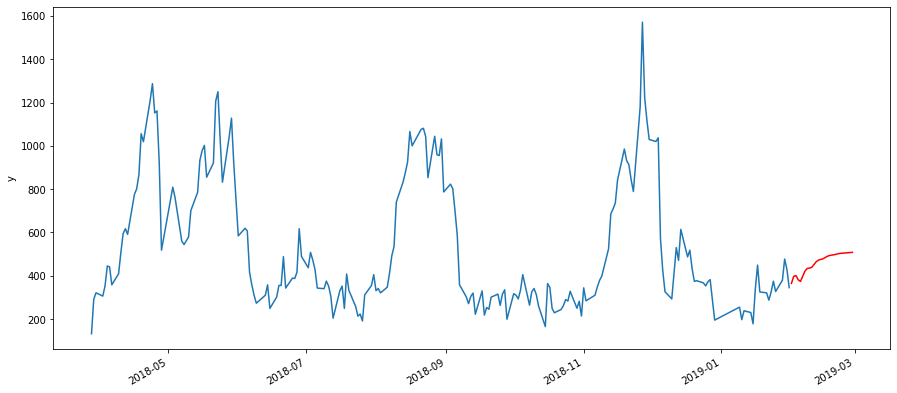

In [ ]:
diff_forecast = df[['target']]
date_list = [datetime.datetime.strptime("2019-02-01", "%Y-%m-%d") + relativedelta(days=x) for x in range(0,28)]
future = pd.DataFrame(index=date_list, columns=diff_forecast.columns)
diff_forecast = pd.concat([diff_forecast, future])
diff_forecast['forecast'] = np.nan
diff_forecast['forecast'][-28:] = model_diff.forecast(28)

plt.figure(figsize=(15,7))
diff_forecast.target.plot()
diff_forecast.forecast.plot(color='r')
plt.ylabel('y')
plt.show()

In [ ]:
diff_forecast

,target,forecast
2018-03-28,132,NaN
2018-03-29,291,NaN
2018-03-30,321,NaN
2018-04-02,306,NaN
2018-04-03,353,NaN
...,...,...
2019-02-24,NaN,504.461953
2019-02-25,NaN,505.232296
2019-02-26,NaN,506.291068
2019-02-27,NaN,507.214342


### Period = 60

Подбор параметров и обучение моделей с периодом, равным 60, заняло очень много времени, поэтому здесь приведены скриншоты результатов перебора параметров, сделанных в другом ноутбуке. Приведено обучение только лучших моделей и их прогнозы.

In [ ]:
period = 60
df['target_season_diff_60'] = df.target - df.target.shift(period)
df['target_diff2_60'] = df.target_season_diff_60 - df.target_season_diff_60.shift(1)


#### 1. Модель для сезонного и обычного дифференцирования

Скрин подбора параметров:
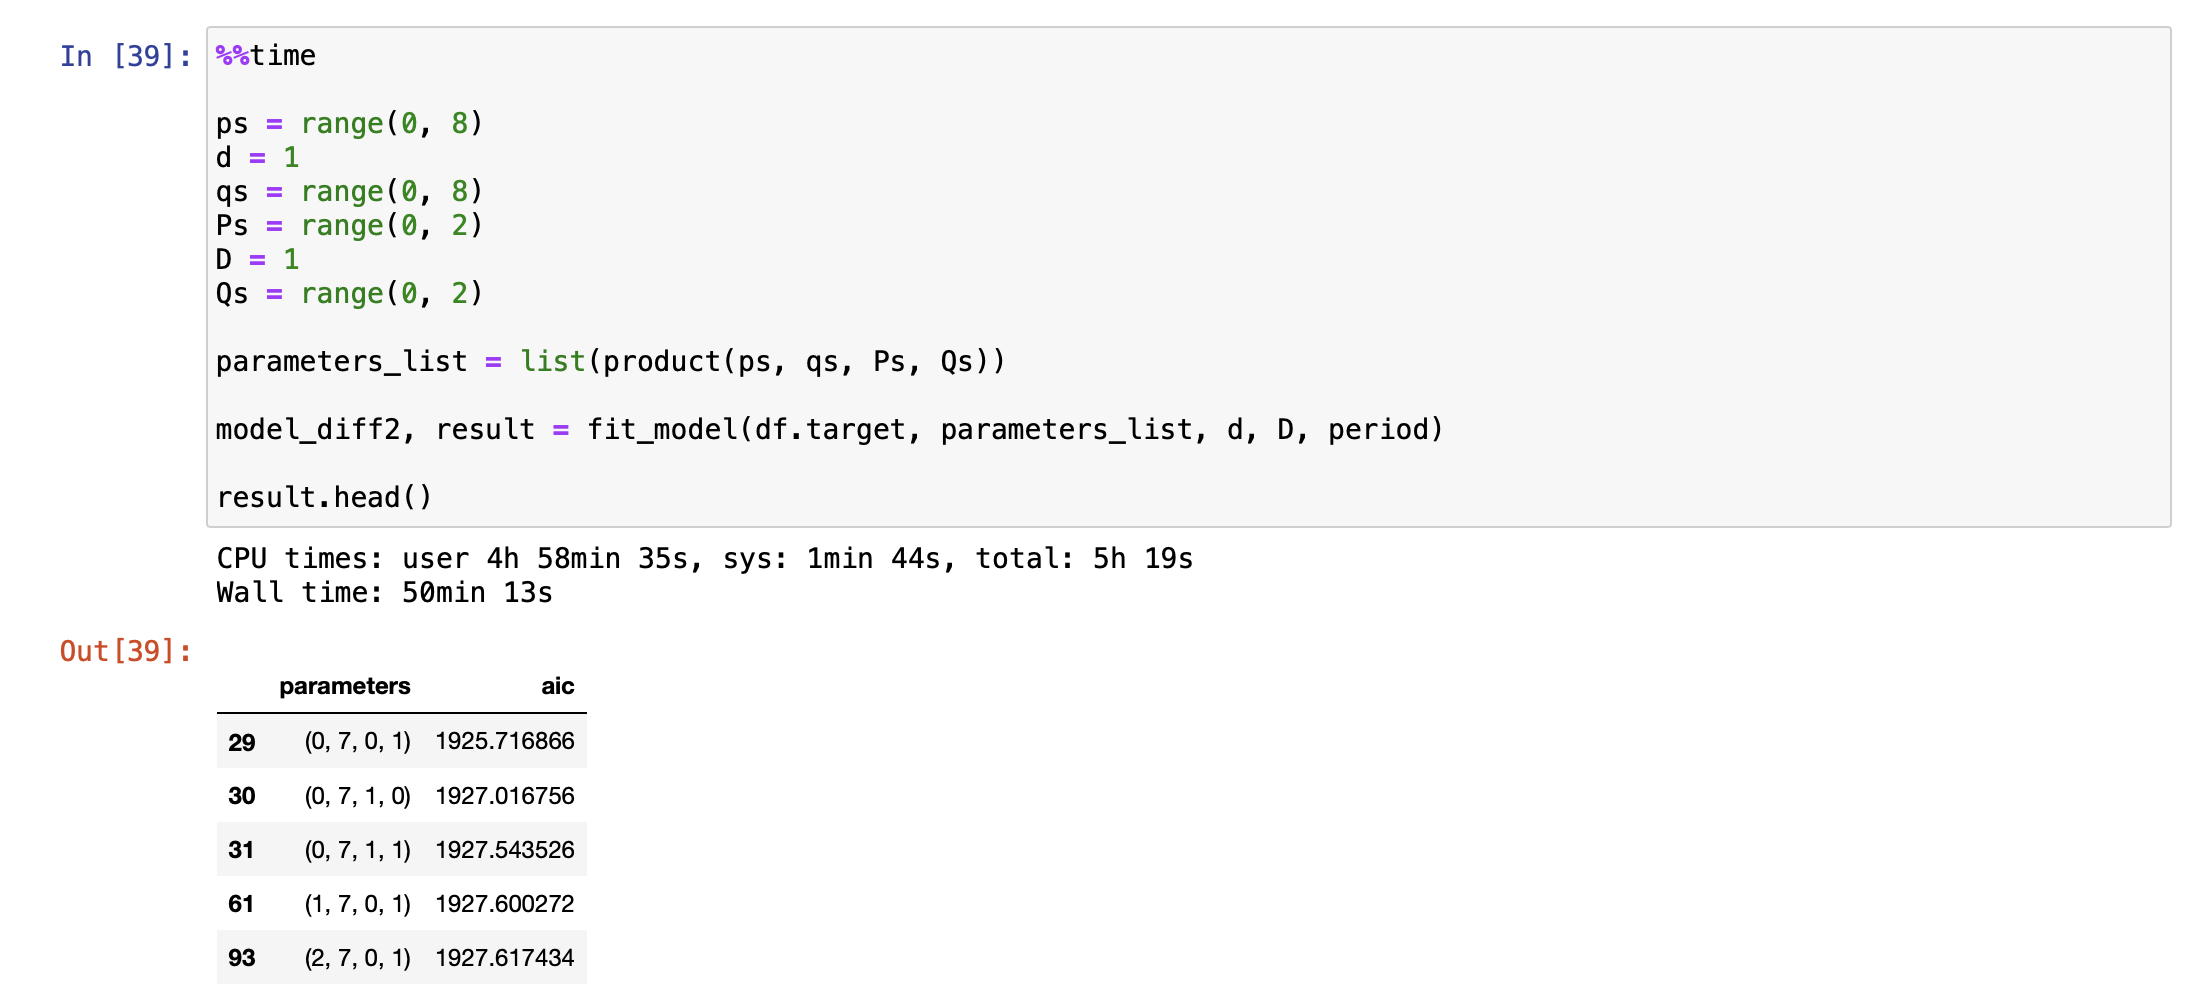

Обучаем лучшую модель:

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


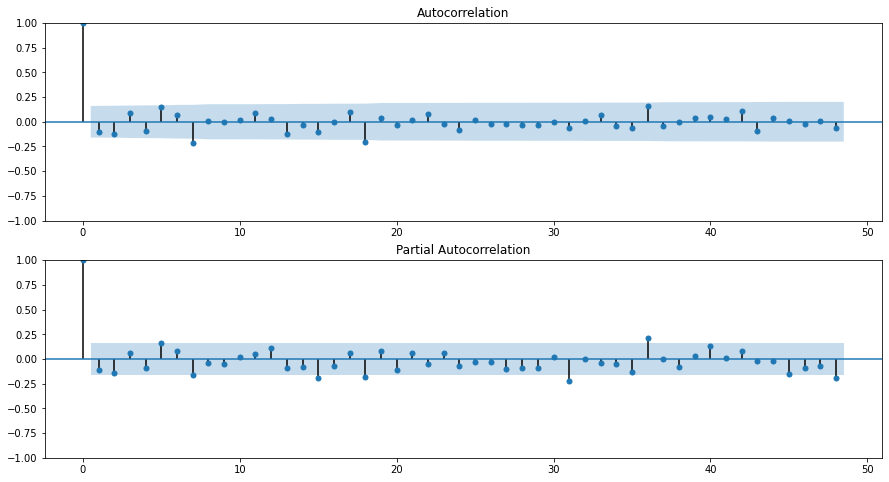

In [ ]:
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot(211)
plot_acf(df.target_diff2_60[period+1:].values.squeeze(), lags=48, ax=ax1)
ax2 = plt.subplot(212)
plot_pacf(df.target_diff2_60[period+1:].values.squeeze(), lags=48, ax=ax2)
plt.show()

In [ ]:
warnings.filterwarnings('ignore')

model_diff2_60 = sm.tsa.statespace.SARIMAX(df.target, order=(0, 1, 7), 
                                           seasonal_order=(0, 1, 1, period)).fit(disp=-1)

aic = model_diff2_60.aic
warnings.filterwarnings('default')
print(aic)


1925.7168658106582


In [ ]:
print(model_diff2_60.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               target   No. Observations:                  211
Model:             SARIMAX(0, 1, 7)x(0, 1, [1], 60)   Log Likelihood                -953.858
Date:                              Sun, 13 Mar 2022   AIC                           1925.717
Time:                                      18:55:15   BIC                           1952.813
Sample:                                           0   HQIC                          1936.725
                                              - 211                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0292      0.076     -0.383      0.702      -0.179       0.120
ma.L2         -0.13

Критерий Стьюдента: p=0.742143
Критерий Дики-Фуллера: p=0.000000


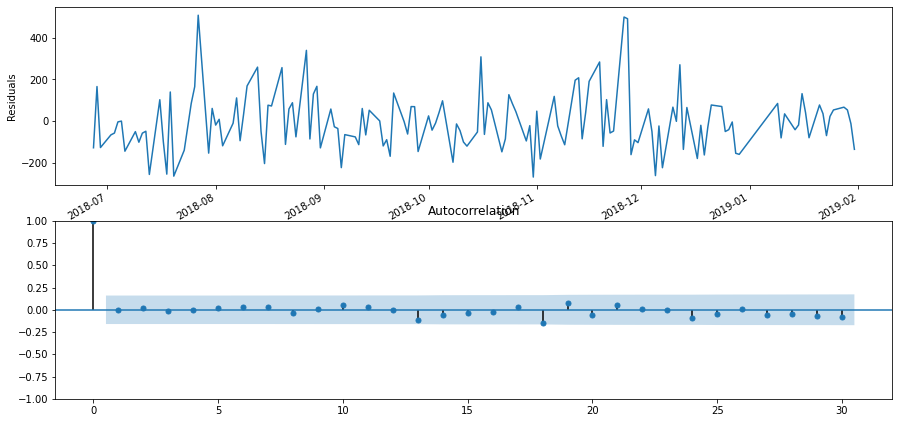

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(211)
model_diff2_60.resid[period+1:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
plot_acf(model_diff2_60.resid[period+1:].values.squeeze(), lags=30, ax=ax)

print("Критерий Стьюдента: p=%f" % scs.ttest_1samp(model_diff2_60.resid[period+1:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % adfuller(model_diff2_60.resid[period+1:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). 

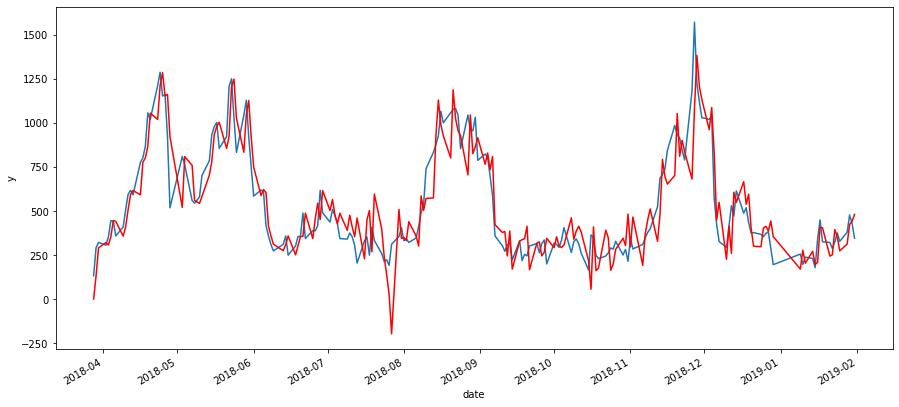

In [ ]:
y_true = df.target
y_pred = model_diff2_60.fittedvalues

plt.figure(figsize=(15,7))
y_true.plot()
y_pred.plot(color='r')
plt.ylabel('y')
plt.show()

Прогнозируем:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


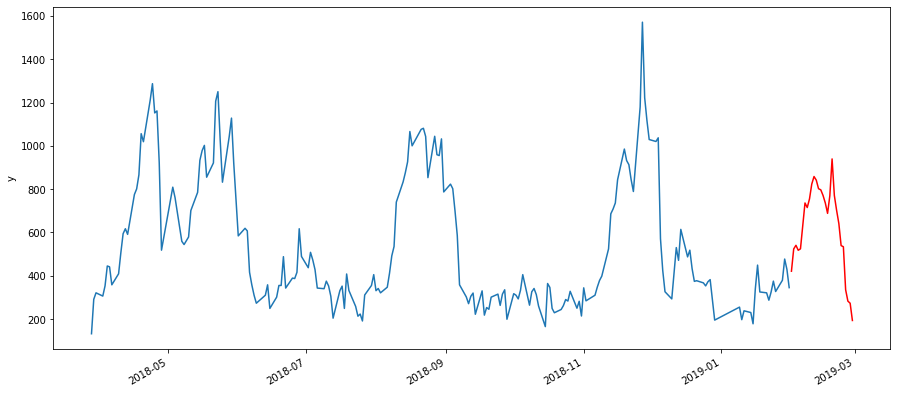

In [ ]:
diff2_60_forecast = df[['target']]
date_list = [datetime.datetime.strptime("2019-02-01", "%Y-%m-%d") + relativedelta(days=x) for x in range(0,28)]
future = pd.DataFrame(index=date_list, columns=diff2_60_forecast.columns)
diff2_60_forecast = pd.concat([diff2_60_forecast, future])
diff2_60_forecast['forecast'] = np.nan
diff2_60_forecast['forecast'][-28:] = model_diff2_60.forecast(28)

plt.figure(figsize=(15,7))
diff2_60_forecast.target.plot()
diff2_60_forecast.forecast.plot(color='r')
plt.ylabel('y')
plt.show()

In [ ]:
diff2_60_forecast

,target,forecast
2018-03-28,132,NaN
2018-03-29,291,NaN
2018-03-30,321,NaN
2018-04-02,306,NaN
2018-04-03,353,NaN
...,...,...
2019-02-24,NaN,533.902008
2019-02-25,NaN,335.156298
2019-02-26,NaN,282.680254
2019-02-27,NaN,272.953327


#### 2. Модель для сезонного дифференцирования

Скрин подбора параметров:
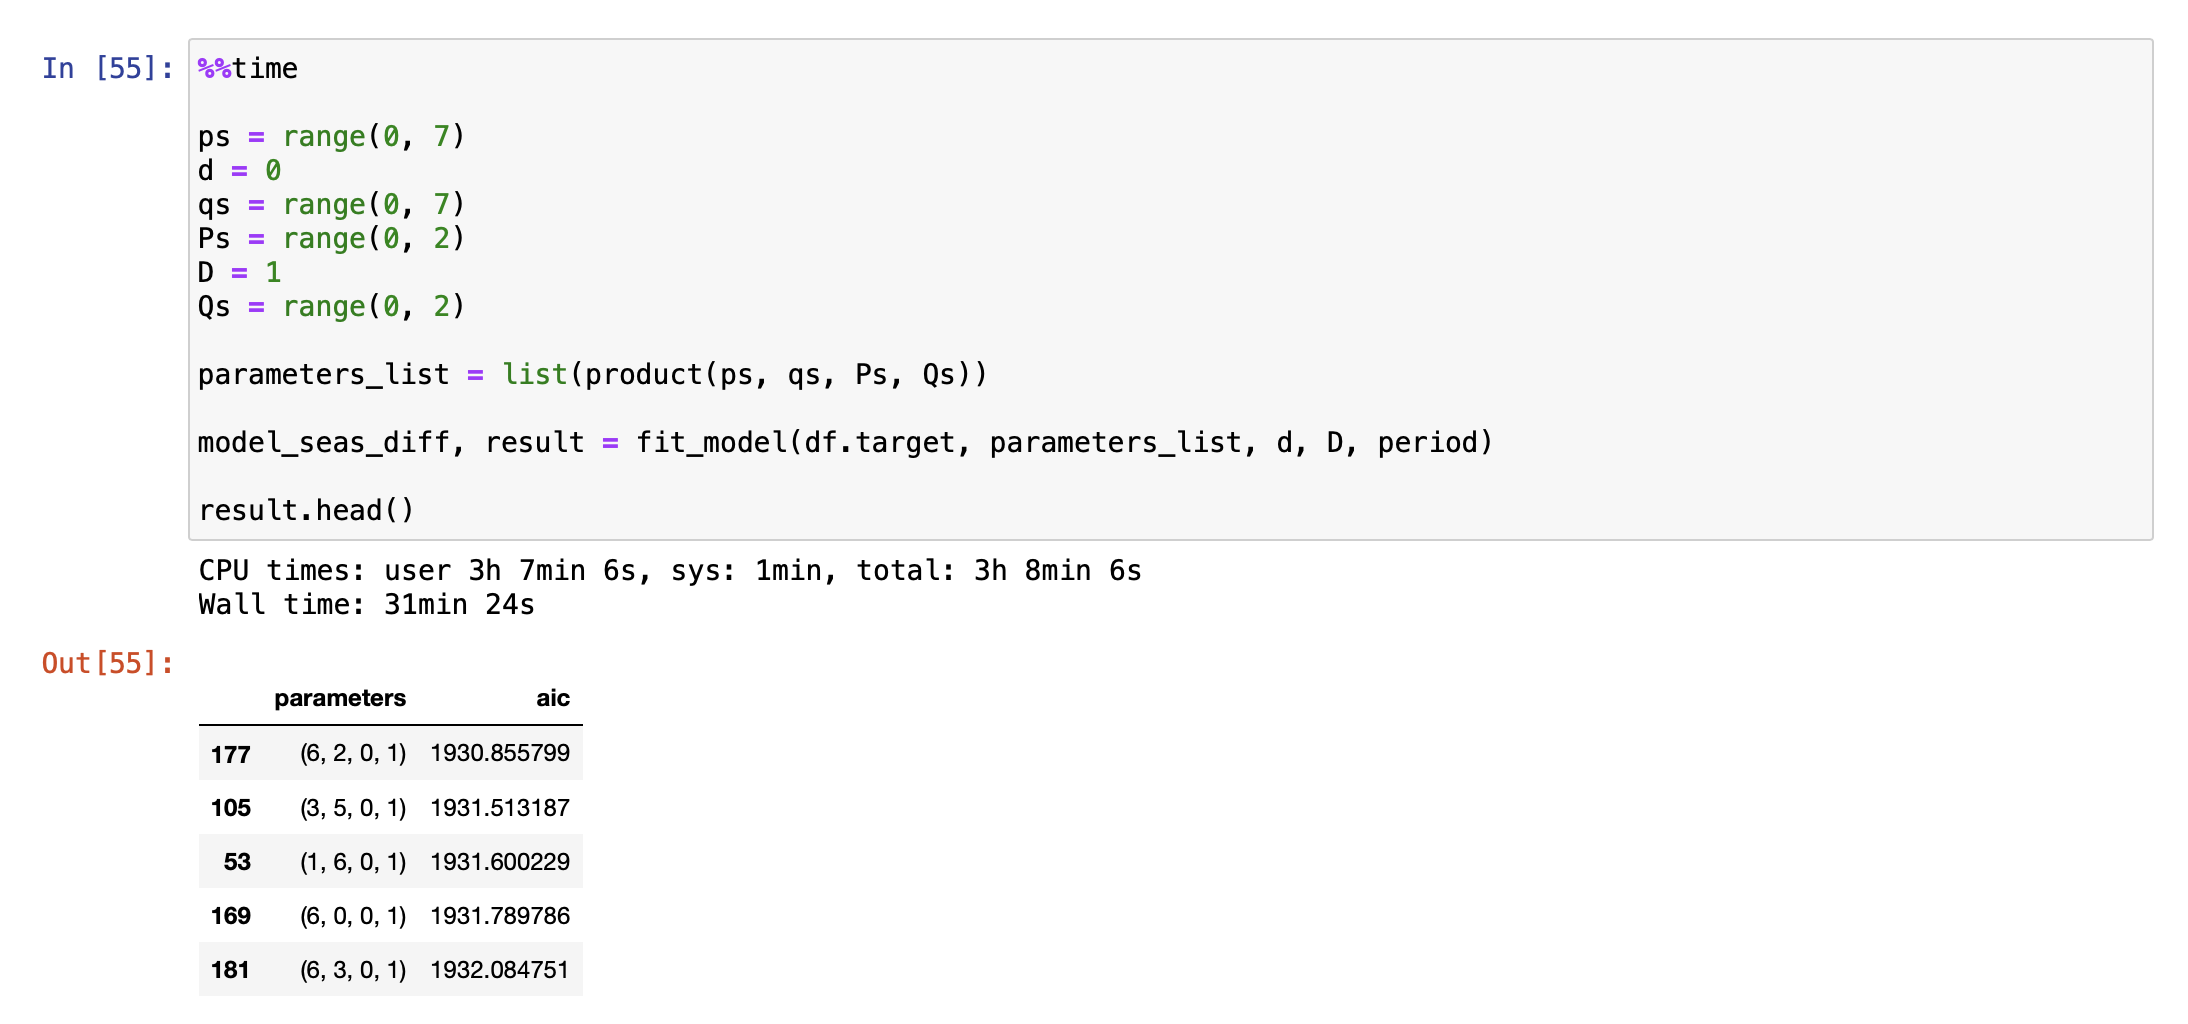

Обучаем лучшую модель:

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


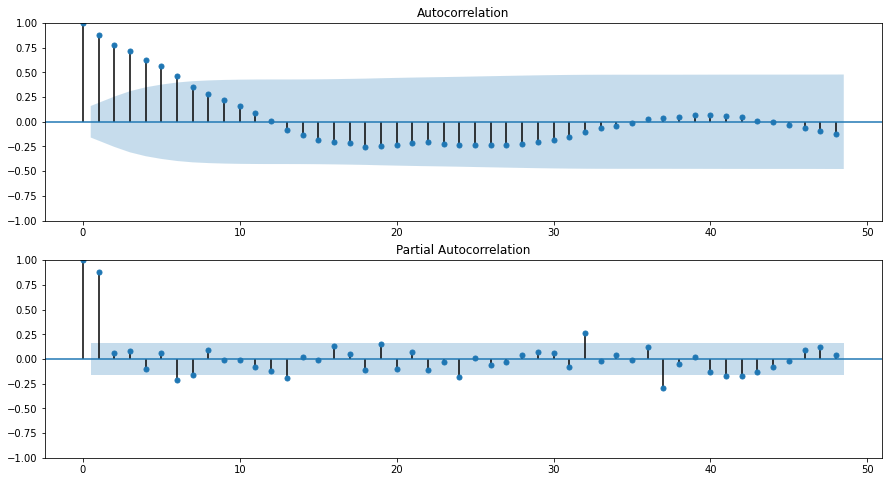

In [ ]:
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot(211)
plot_acf(df.target_season_diff_60[period:].values.squeeze(), lags=48, ax=ax1)
ax2 = plt.subplot(212)
plot_pacf(df.target_season_diff_60[period:].values.squeeze(), lags=48, ax=ax2)
fig.show()

In [ ]:
warnings.filterwarnings('ignore')

model_seas_diff_60 = sm.tsa.statespace.SARIMAX(df.target, order=(6, 0, 2), 
                                               seasonal_order=(0, 1, 1, period)).fit(disp=-1)

aic = model_seas_diff_60.aic
warnings.filterwarnings('default')
print(aic)

1930.854206482777


In [ ]:
print(model_seas_diff_60.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               target   No. Observations:                  211
Model:             SARIMAX(6, 0, 2)x(0, 1, [1], 60)   Log Likelihood                -955.427
Date:                              Sun, 13 Mar 2022   AIC                           1930.854
Time:                                      18:57:29   BIC                           1961.027
Sample:                                           0   HQIC                          1943.112
                                              - 211                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5951      0.195      8.166      0.000       1.212       1.978
ar.L2         -1.33

Критерий Стьюдента: p=0.900902
Критерий Дики-Фуллера: p=0.000000


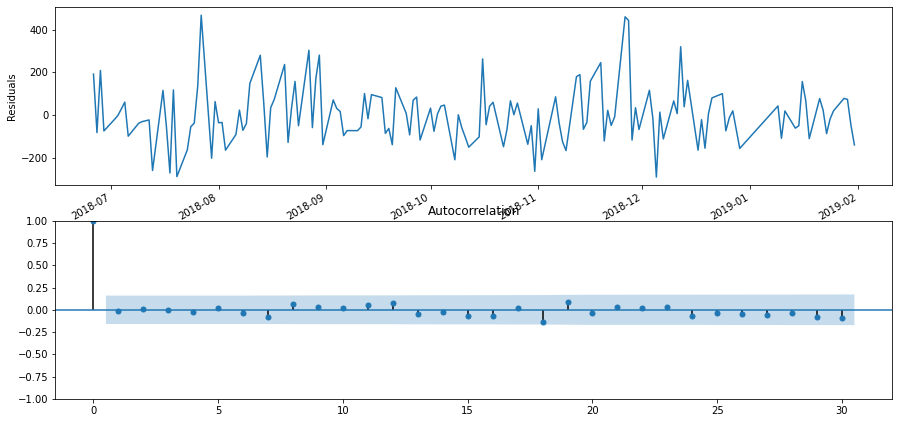

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(211)
model_seas_diff_60.resid[period:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
plot_acf(model_seas_diff_60.resid[period:].values.squeeze(), lags=30, ax=ax)

print("Критерий Стьюдента: p=%f" % scs.ttest_1samp(model_seas_diff_60.resid[period:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % adfuller(model_seas_diff_60.resid[period:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). 

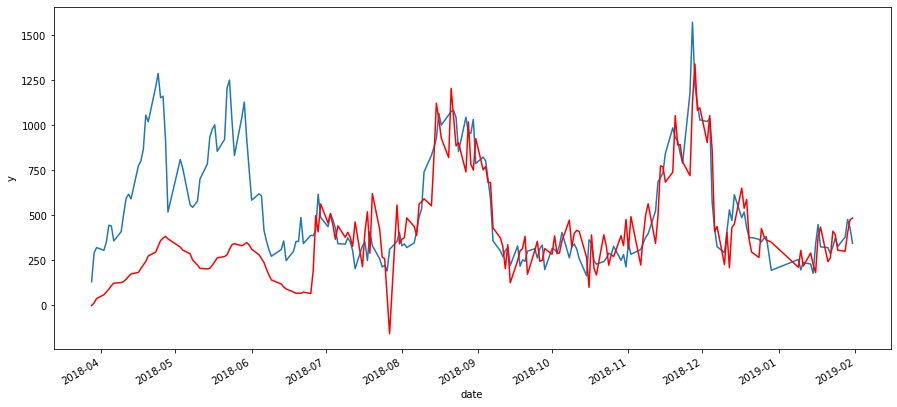

In [ ]:
y_true = df.target
y_pred = model_seas_diff_60.fittedvalues

plt.figure(figsize=(15,7))
y_true.plot()
y_pred.plot(color='r')
plt.ylabel('y')
plt.show()

Прогнозируем:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


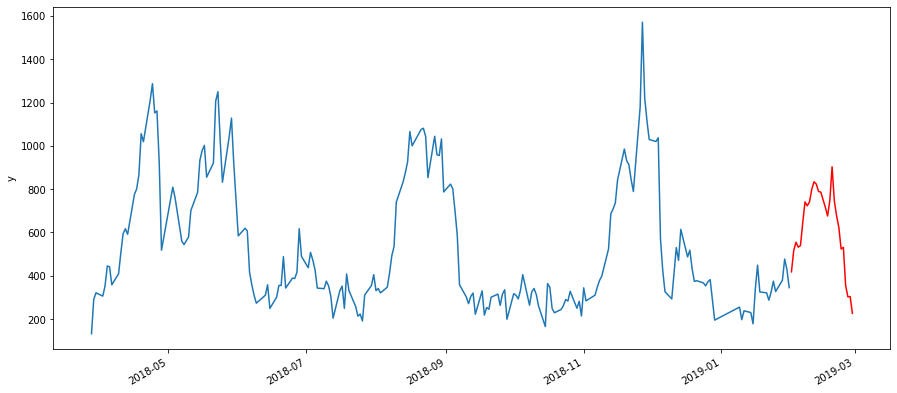

In [ ]:
seas_diff_60_forecast = df[['target']]
date_list = [datetime.datetime.strptime("2019-02-01", "%Y-%m-%d") + relativedelta(days=x) for x in range(0,28)]
future = pd.DataFrame(index=date_list, columns=seas_diff_60_forecast.columns)
seas_diff_60_forecast = pd.concat([seas_diff_60_forecast, future])
seas_diff_60_forecast['forecast'] = np.nan
seas_diff_60_forecast['forecast'][-28:] = model_seas_diff_60.forecast(28)

plt.figure(figsize=(15,7))
seas_diff_60_forecast.target.plot()
seas_diff_60_forecast.forecast.plot(color='r')
plt.ylabel('y')
plt.show()

In [ ]:
seas_diff_60_forecast

,target,forecast
2018-03-28,132,NaN
2018-03-29,291,NaN
2018-03-30,321,NaN
2018-04-02,306,NaN
2018-04-03,353,NaN
...,...,...
2019-02-24,NaN,531.128819
2019-02-25,NaN,354.944492
2019-02-26,NaN,302.513198
2019-02-27,NaN,303.419189


### Вывод
Сравнив все модели по Akaike information criterion и Log likelihood видим, что лучше всего приближает данные модель SARIMAX(0, 1, 7)x(0, 1, [1], 60). С сезонностью 60 рабочих дней, без авторегрессионной части, с одним взятием разностей, скользящим средним 7-го порядка, одним сезонным дефференцированием и сезонным скользящим средним первого порядка. Финальный прогноз находится в прикрепленном файле (result.csv), сделали для рабочих дней.